In [1]:
import sys
import os

from unityagents import UnityEnvironment
import torch
import numpy as np
import matplotlib.pyplot as plt

from agent import Agent

from scorecounter import ScoreCounter


In [2]:
env = UnityEnvironment(file_name="Banana.app")

Mono path[0] = '/Users/soeren/Library/Mobile Documents/com~apple~CloudDocs/development/udacity/macmini/project1-banana/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/soeren/Library/Mobile Documents/com~apple~CloudDocs/development/udacity/macmini/project1-banana/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
def gather(env_info):
    state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0] 
    return state, reward, done

In [5]:
def show_stats(sc):
    print(f'\rEpisode {sc.episode}\tAverage Score: {sc.window_mean:.2f}', end='')
    if sc.episode % 100 == 0:
        print(f'\rEpisode {sc.episode}\tAverage Score: {sc.window_mean:.2f}')

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
        gamma=0.99, alpha=0.5e-4, buffer_size=int(1e5), batch_size=64,
        tau=1e-3, update_every=4, fc1_scalar=1, fc2_scalar=1):

    print('\n', '='*40)
    print(f'dqn hyperparameters:\nepsilon [decay {eps_decay}, min {eps_end}, start {eps_start}], gamma: {gamma}')
    print(f'tau {tau}, buffer size: {buffer_size}, batch size: {batch_size}, update every: {update_every}')
    print(f'alpha {alpha}, hidden layer 1 scalar: {fc1_scalar}, hidden layer 2 scalar: {fc2_scalar}\n', '='*40)

    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = len(env_info.vector_observations[0])
    
    agent = Agent(state_size=state_size, action_size=action_size, gamma=gamma, alpha=alpha, 
                  buffer_size=buffer_size, batch_size=batch_size, tau=tau, update_every=update_every,
                  fc1_scalar=fc1_scalar, fc2_scalar=fc2_scalar)
    
    sc = ScoreCounter()
    eps = eps_start

    for _ in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = gather(env_info)[0]
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = gather(env_info)
            agent.step(state, action, reward, next_state, done)
            sc.add(reward)
            state = next_state
            if done:
                break 
        show_stats(sc)
        sc.next()
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

    print(f'\nEnvironment solved in {sc.first_reached(13):d} episodes!\tMax Average Score: {sc.max_window_mean:.2f}')
    torch.save(agent.qnetwork_local.state_dict(), f'model-gamma{gamma}.pth')

    return sc


In [45]:
def subplot_score(sub, sc, title):
    x = np.arange(len(sc.scores))
    scores = sc.scores
    means = sc.score_window_means
    
    sub.plot(x, scores, alpha=0.5)
    sub.plot(x, means, color='red')

    sub.set(xlabel='Episode #', ylabel='Score')
    sub.axhline(y=13, color='green', linestyle='dashed')
    sub.axhline(y=15, color='lightgray', linestyle='dashed')
    sub.set_title(title)

def plot_scores(scs, title, title_values, save_as='default.png'):
    scs = np.atleast_1d(scs)
    _, subs = plt.subplots(1, len(scs), figsize=(15,5))
    for sub, sc, title_value in zip(np.atleast_1d(subs), scs, np.atleast_1d(title_values)):
        subplot_score(sub, sc, f'{title}{title_value}') 
    plt.savefig(save_as)
    plt.show()

def plot_avg_means(scs, names, save_as='default.png'):
    fig = plt.figure(figsize=(15,5))
    for sc, name in zip(scs, names):
        plt.plot(np.arange(len(sc.score_window_means)), sc.score_window_means, label=f'{name}')
    plt.axhline(y=13, color='green', linestyle='dashed')
    plt.axhline(y=15, color='lightgray', linestyle='dashed')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.grid(True, color='gainsboro')
    plt.legend()
    plt.savefig(save_as)
    plt.show()

In [8]:
gammas = [0.9, 0.99, 0.999]
scs = []

for gamma in gammas:
    sc = dqn(gamma=gamma)
    scs.append(sc)


dqn hyperparameters:
epsilon [decay 0.995, min 0.01, start 1.0], gamma: 0.9
tau 0.001, buffer size: 100000, batch size: 64, update every: 4
alpha 5e-05, hidden layer 1 scalar: 1, hidden layer 2 scalar: 1
 features: [Input: 37, Layer 1: 37, Layer 2: 37, output: 4 ]
 features: [Input: 37, Layer 1: 37, Layer 2: 37, output: 4 ]
Episode 100	Average Score: 0.67
Episode 200	Average Score: 3.21
Episode 300	Average Score: 6.49
Episode 400	Average Score: 7.40
Episode 500	Average Score: 6.74
Episode 600	Average Score: 8.18
Episode 700	Average Score: 10.08
Episode 800	Average Score: 11.55
Episode 900	Average Score: 12.50
Episode 1000	Average Score: 13.17
Episode 1100	Average Score: 13.02
Episode 1200	Average Score: 14.07
Episode 1300	Average Score: 13.70
Episode 1400	Average Score: 14.34
Episode 1500	Average Score: 14.31
Episode 1600	Average Score: 14.91
Episode 1700	Average Score: 15.15
Episode 1800	Average Score: 15.40
Episode 1900	Average Score: 15.10
Episode 2000	Average Score: 15.81

Environ

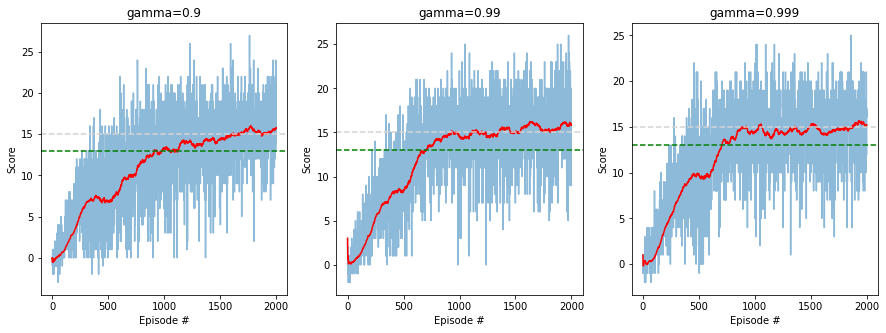

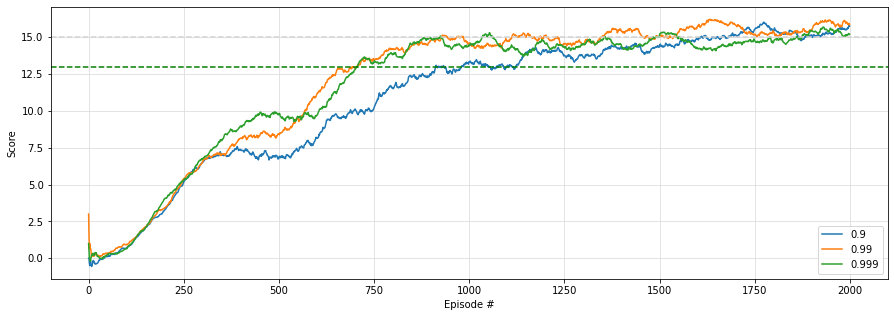

In [49]:
plot_scores(scs, 'gamma=', gammas, save_as='images/gamma-test.png')
plot_avg_means(scs, gammas,  save_as='images/gamma-test-comp.png')

In [11]:
scs2 = []

for gamma in gammas:
    sc = dqn(gamma=gamma, fc1_scalar=2, fc2_scalar=2)
    scs2.append(sc)


dqn hyperparameters:
epsilon [decay 0.995, min 0.01, start 1.0], gamma: 0.9
tau 0.001, buffer size: 100000, batch size: 64, update every: 4
alpha 5e-05, hidden layer 1 scalar: 2, hidden layer 2 scalar: 2
 features: [Input: 37, Layer 1: 74, Layer 2: 74, output: 4 ]
 features: [Input: 37, Layer 1: 74, Layer 2: 74, output: 4 ]
Episode 100	Average Score: 0.21
Episode 200	Average Score: 2.41
Episode 300	Average Score: 5.30
Episode 400	Average Score: 7.39
Episode 500	Average Score: 8.00
Episode 600	Average Score: 10.33
Episode 700	Average Score: 12.16
Episode 800	Average Score: 13.76
Episode 900	Average Score: 13.84
Episode 1000	Average Score: 14.39
Episode 1100	Average Score: 14.41
Episode 1200	Average Score: 14.84
Episode 1300	Average Score: 14.39
Episode 1400	Average Score: 14.98
Episode 1500	Average Score: 14.38
Episode 1600	Average Score: 15.17
Episode 1700	Average Score: 15.47
Episode 1800	Average Score: 15.58
Episode 1900	Average Score: 15.43
Episode 2000	Average Score: 15.67

Enviro

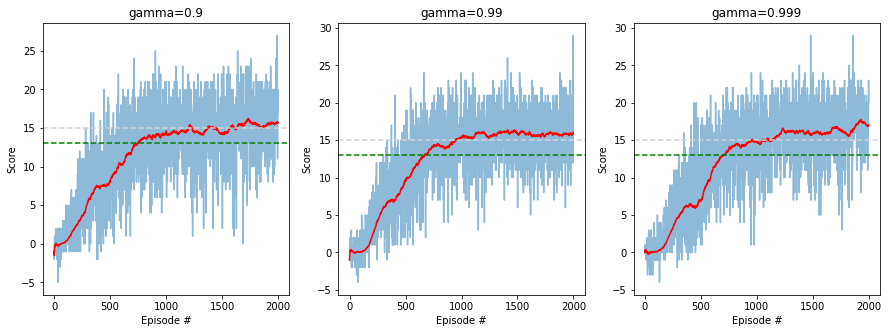

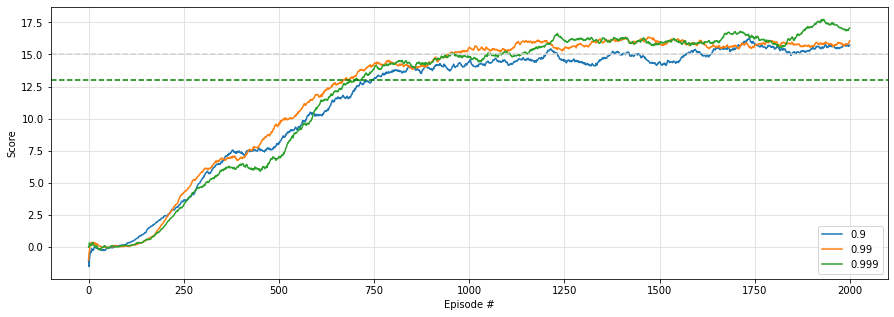

In [50]:
plot_scores(scs2, 'gamma=', gammas, save_as='images/gamma-test-doubled-fcl.png')
plot_avg_means(scs2, gammas, save_as='images/gamma-test-doubled-fcl-comp.png')

In [20]:
alphas=[5e-3, 2.5e-3, 1e-3, 7.5e-4, 5e-4, 2.5e-4]
scs3 = []

for alpha in alphas:
    sc = dqn(gamma=0.99, alpha=alpha, fc1_scalar=2, fc2_scalar=2)
    scs3.append(sc)


dqn hyperparameters:
epsilon [decay 0.995, min 0.01, start 1.0], gamma: 0.99
tau 0.001, buffer size: 100000, batch size: 64, update every: 4
alpha 0.005, hidden layer 1 scalar: 2, hidden layer 2 scalar: 2
 features: [Input: 37, Layer 1: 74, Layer 2: 74, output: 4 ]
 features: [Input: 37, Layer 1: 74, Layer 2: 74, output: 4 ]
Episode 100	Average Score: 0.25
Episode 200	Average Score: 1.64
Episode 300	Average Score: 4.91
Episode 400	Average Score: 6.96
Episode 500	Average Score: 9.74
Episode 600	Average Score: 12.02
Episode 700	Average Score: 11.69
Episode 800	Average Score: 11.07
Episode 900	Average Score: 12.49
Episode 1000	Average Score: 13.50
Episode 1100	Average Score: 13.20
Episode 1200	Average Score: 12.22
Episode 1300	Average Score: 12.03
Episode 1400	Average Score: 12.17
Episode 1500	Average Score: 11.97
Episode 1600	Average Score: 12.32
Episode 1700	Average Score: 12.26
Episode 1800	Average Score: 11.83
Episode 1900	Average Score: 12.96
Episode 2000	Average Score: 12.45

Envir

In [41]:
scs4 = scs3 + [scs2[1]]
all_alphas = alphas + [1e-5]

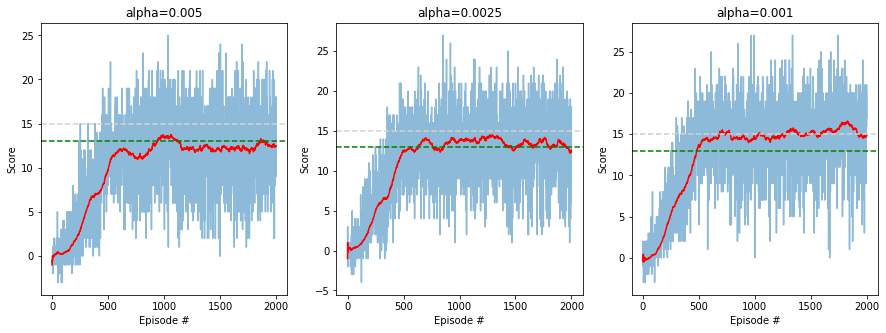

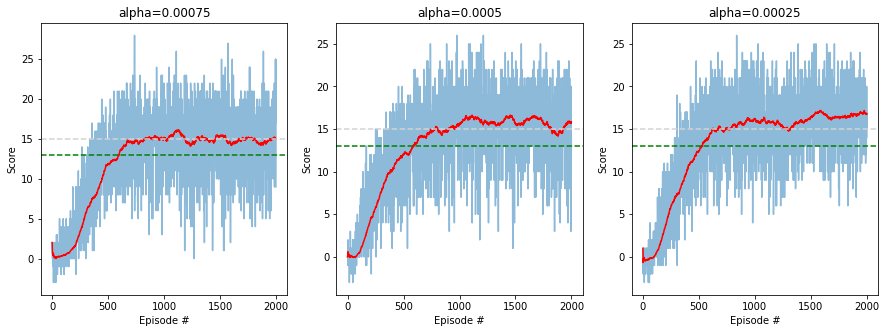

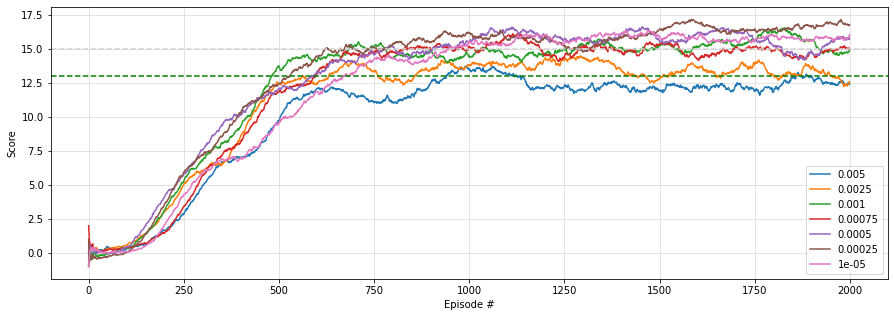

In [51]:
plot_scores(scs3[:3], 'alpha=', alphas[:3], save_as='images/alpha-test1.png')
plot_scores(scs3[-3:], 'alpha=', alphas[-3:], save_as='images/alpha-test2.png')
plot_avg_means(scs4, all_alphas,  save_as='images/alpha-test-comp.png')